## Предобработка в пайплайнах
* Задача: предсказание рейтинга красного вина
* Датасет:
    * Name - *название*
    * Country - *страна изготовителя*
    * Region - *регион изготовления*
    * Winery - *название винодельни*
    * Rating - *рейтинг вина*
    * NumberOfRatings - *число оценок*
    * Price - *цена*
    * Year - *год вина*

In [102]:
#загрузим основные библиотеки
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import RidgeCV
 
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer #Создание объекта преобразования данных

import matplotlib.pyplot as plt

import joblib #библиотека для сохранения pipeline


In [103]:
# Загрузка данных
df_wine = pd.read_csv('Red.csv')
df_wine.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016


In [104]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8666 entries, 0 to 8665
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             8666 non-null   object 
 1   Country          8666 non-null   object 
 2   Region           8666 non-null   object 
 3   Winery           8666 non-null   object 
 4   Rating           8666 non-null   float64
 5   NumberOfRatings  8666 non-null   int64  
 6   Price            8666 non-null   float64
 7   Year             8666 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 541.8+ KB


> * Пропусков в датасете нет.
> * Признаки Country, Region, Winery, Year - категориальные
> * Признаки Rating, NumberOfRatings, Price - непрерывные

**Исследование данных**

In [105]:
df_wine[df_wine.select_dtypes(['float', 'int']).columns].describe()


,Rating,NumberOfRatings,Price
count,8666.000000,8666.000000,8666.000000
mean,3.890342,415.287445,39.145065
std,0.308548,899.726373,84.936307
min,2.500000,25.000000,3.550000
25%,3.700000,66.000000,10.680000
50%,3.900000,157.000000,18.200000
75%,4.100000,401.000000,38.142500
max,4.800000,20293.000000,3410.790000


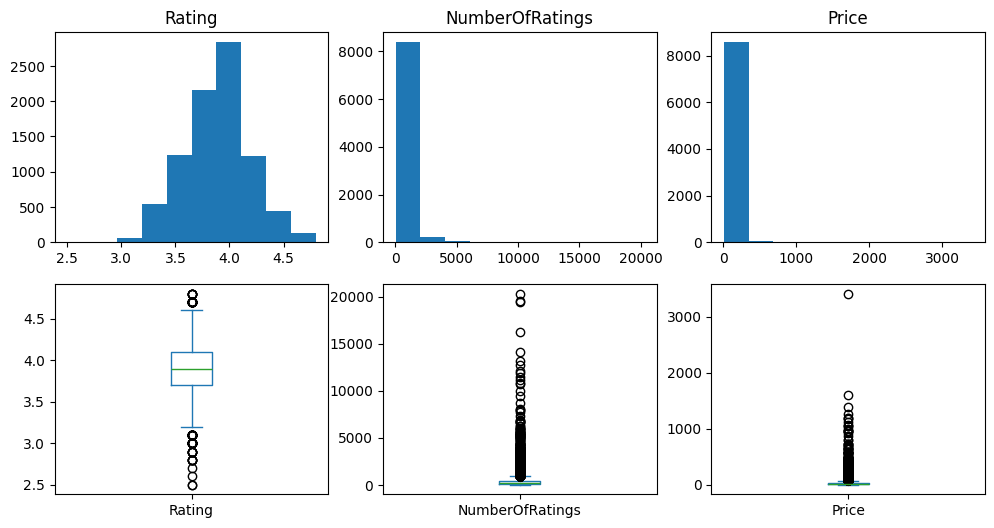

In [106]:
fig, ax = plt.subplots(2,3,figsize=(12,6))
cols = list(df_wine.select_dtypes(['float', 'int']).columns)
for i, item in enumerate(cols):
    df_wine[item].plot(kind='hist', ax=ax[0][i], title=item, ylabel='')
    df_wine[item].plot(kind='box', ax=ax[1][i], ylabel='');

> * Целевой признак Rating имеет равномерное распределение
> * Признаки NumberOfRatings и Price сильно смещены влево. В признаке Price есть один выброс, вдвое превышающий остальные значения. В признаке NumberOfRatings также наблюдаются выбросы.
> * Разница в значениях признаков также велика. Требуется стандартизация.

In [107]:
#Выведем данные о выбросах
df_wine[(df_wine['Price']>3000)|(df_wine['NumberOfRatings']>15000)]

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
1623,Cinquanta Collezione 2012,Italy,Vino d'Italia,San Marzano,4.3,16262,17.57,2012
2201,Cinquanta Collezione N.V.,Italy,Vino d'Italia,San Marzano,4.3,19454,16.38,N.V.
2203,Pinot Noir 2017,United States,California,Meiomi,4.1,19489,26.55,2017
2328,Rioja Reserva 2014,Spain,Rioja,Marqués de Riscal,4.1,20293,15.39,2014
2344,Pomerol 2012,France,Pomerol,Pétrus,4.7,204,3410.79,2012


In [108]:
cols = list(df_wine.drop('Name', axis=1).select_dtypes('object').columns)
df_wine[cols].describe()

,Country,Region,Winery,Year
count,8666,8666,8666,8666
unique,30,624,2714,32
top,Italy,Rioja,Errazuriz,2016
freq,2650,325,40,1776


> * Число регионов 624, большое для кодирования OneHotEncoding, пробуем закодировать регионы порядковым кодированием.

### Трансформация данных, обучение модели и предсказание методом Pipeline

**Подготовка трансформации данных при помощи ColumnTransformer**

In [109]:
# Подготовка трансформации данных при помощи ColumnTransformer
ct = make_column_transformer(
     (StandardScaler(), ['Price']),
    (OneHotEncoder(), ['Country']),
     (OrdinalEncoder(), ['Region']))
print(ct)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(), ['Price']),
                                ('onehotencoder', OneHotEncoder(), ['Country']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['Region'])])


#### Pipeline для случайного леса

In [110]:
# Создание объекта pipeline
pipeline = Pipeline([('ct', ct), ('rf', RandomForestRegressor(random_state=42))], verbose=True)

In [111]:
# Создание обучающих наборов
X = df_wine[['Price', 'Country', 'Region']]
y = df_wine['Rating']

In [112]:
# Обучение pipeline
pipeline.fit(X, y)

[Pipeline] ................ (step 1 of 2) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=  16.7s


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Region'])])),
                ('rf', RandomForestRegressor(random_state=42))],
         verbose=True)

In [113]:
pd.DataFrame(pipeline['ct'].transform(X).toarray(), columns = ['Price']+ pipeline['ct'].transformers_[1][1].get_feature_names_out().tolist()+['Region'])

,Price,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Chile,Country_China,Country_Croatia,...,Country_Romania,Country_Slovakia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_United States,Country_Uruguay,Region
0,0.657648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,408.0
1,-0.278402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,286.0
2,-0.373184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,542.0
3,-0.358231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0
4,-0.117684,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8661,-0.266981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,290.0
8662,-0.224358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,309.0
8663,-0.178910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,250.0
8664,-0.387784,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,509.0


In [114]:
#Предсказание и метрики на наборе
y_pred = pipeline.predict(X)
rmse_train = root_mean_squared_error(y,y_pred)
print('RMSE metrics: {:.4f}'.format(rmse_train))

RMSE metrics: 0.0857


**Проверка созданного Pipeline на тестовых данных**

In [115]:
# Загрузим тестовый набор данных
df_wine_test = pd.read_csv('Red_test.csv')
df_wine_test.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
0,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017
1,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
2,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
3,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016
4,Capatosta 2015,Italy,Toscana,Poggio Argentiera,3.8,101,19.90,2015


In [116]:
df_wine_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             280 non-null    object 
 1   Country          280 non-null    object 
 2   Region           280 non-null    object 
 3   Winery           280 non-null    object 
 4   Rating           280 non-null    float64
 5   NumberOfRatings  280 non-null    int64  
 6   Price            280 non-null    float64
 7   Year             280 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 17.6+ KB


In [117]:
# Создадим тестовые наборы данных
X_test = df_wine_test[['Price', 'Country', 'Region']]
y_test = df_wine_test['Rating']

In [118]:
#Выполним предсказание на тестовом наборе и оценим метрики
y_test_pred = pipeline.predict(X_test)
rmse_test = root_mean_squared_error(y_test,y_test_pred)
print('RSME score: {:.4f}'.format(rmse_test))

RSME score: 0.0763


In [119]:
#Сохранение обученного pipeline
joblib.dump(pipeline, 'pipeline_wine.pkl')

['pipeline_wine.pkl']

#### Изменение параметров случайного леса
* Ставим число моделей - 200

In [120]:
# Посмотрим параметры случайного леса
pipeline.get_params()

{'memory': None,
 'steps': [('ct',
   ColumnTransformer(transformers=[('standardscaler', StandardScaler(), ['Price']),
                                   ('onehotencoder', OneHotEncoder(), ['Country']),
                                   ('ordinalencoder', OrdinalEncoder(),
                                    ['Region'])])),
  ('rf', RandomForestRegressor(random_state=42))],
 'verbose': True,
 'ct': ColumnTransformer(transformers=[('standardscaler', StandardScaler(), ['Price']),
                                 ('onehotencoder', OneHotEncoder(), ['Country']),
                                 ('ordinalencoder', OrdinalEncoder(),
                                  ['Region'])]),
 'rf': RandomForestRegressor(random_state=42),
 'ct__force_int_remainder_cols': True,
 'ct__n_jobs': None,
 'ct__remainder': 'drop',
 'ct__sparse_threshold': 0.3,
 'ct__transformer_weights': None,
 'ct__transformers': [('standardscaler', StandardScaler(), ['Price']),
  ('onehotencoder', OneHotEncoder(), ['Country'

In [121]:
# Установим n_estimators 200
pipeline.set_params(rf__n_estimators=200)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Region'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=200, random_state=42))],
         verbose=True)

In [122]:
#Переобучим pipeline
pipeline.fit(X, y)

[Pipeline] ................ (step 1 of 2) Processing ct, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing rf, total=  42.2s


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Region'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=200, random_state=42))],
         verbose=True)

In [123]:
# Выполним предсказания и выведем метрики
y_pred = pipeline.predict(X)
y_test_pred = pipeline.predict(X_test)
rmse_rf200_train = root_mean_squared_error(y, y_pred)
rmse_rf200_test = root_mean_squared_error(y_test, y_test_pred)
print('Train sample RMSE: {:.4f}'.format(rmse_rf200_train))
print('Test  sample RMSE: {:.4f}'.format(rmse_rf200_test))

Train sample RMSE: 0.0853
Test  sample RMSE: 0.0760


### Создание модели pipeline StackingRegressor
* модели: RidgeCV, DecisionTreeRegressor
* метамодель: RandomForestRegressor(n_estimators=10)
* обработка данных та же

In [129]:
#Создаем объект StackingRegressor
stacking_regressor = StackingRegressor([('lr', RidgeCV()),
                         ('dt', DecisionTreeRegressor(random_state=42))],
                        final_estimator=RandomForestRegressor(n_estimators=10, random_state=42),
                        verbose=10,
                        n_jobs=-1)

In [130]:
#Создаем pipeline
pipeline_stacking = Pipeline((('ct', ct), ('str', stacking_regressor)), verbose=True)

In [131]:
#Обучаем pipeline
pipeline_stacking.fit(X, y)

[Pipeline] ................ (step 1 of 2) Processing ct, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing str, total=   9.1s


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Region'])])),
                ('str',
                 StackingRegressor(estimators=[('lr', RidgeCV()),
                                               ('dt',
                                                DecisionTreeRegressor(random_state=42))],
                                   final_estimator=RandomForestRegressor(n_estimators=10,
                                                                         random_state=42),
                                   n_jobs=-1, verbose=10))],
         verbose=True)

In [132]:
# Делаем предсказания для обучющей и тестовой выборок и выводим метрики
y_pred = pipeline_stacking.predict(X)
y_test_pred = pipeline_stacking.predict(X_test)
rmse_stacking_train = root_mean_squared_error(y, y_pred)
rmse_stacking_test = root_mean_squared_error(y_test, y_test_pred)
print('Train sample RMSE: {:.4f}'.format(rmse_stacking_train))
print('Test  sample RMSE: {:.4f}'.format(rmse_stacking_test))

Train sample RMSE: 0.1990
Test  sample RMSE: 0.1797


#### Итоги

In [133]:
print('Обучение всех моделей на признаках Price(стандартизован), Country(one hot encoded), Region(ordinal encoder).')
print('-'*40)
print('Метрики Pipeline RandomForestClassifier с параметрами по-умолчанию:')
print('Train sample RMSE: {:.4f}'.format(rmse_train).rjust(40))
print('Test  sample RMSE: {:.4f}'.format(rmse_test).rjust(40))
print('-'*40)
print('Метрики Pipeline RandomForestClassifier n_estimators=200:')
print('Train sample RMSE: {:.4f}'.format(rmse_rf200_train).rjust(40))
print('Test  sample RMSE: {:.4f}'.format(rmse_rf200_test).rjust(40))
print('-'*40)
print('Метрики Pipeline StackingRegressor(RIdgeCV, DesicionTreeRegressor, meta: RandomForestRegressor(n_estimators=10)):')
print('Train sample RMSE: {:.4f}'.format(rmse_stacking_train).rjust(40))
print('Test  sample RMSE: {:.4f}'.format(rmse_stacking_test).rjust(40))
print('-'*40)

Обучение всех моделей на признаках Price(стандартизован), Country(one hot encoded), Region(ordinal encoder).
----------------------------------------
Метрики Pipeline RandomForestClassifier с параметрами по-умолчанию:
               Train sample RMSE: 0.0857
               Test  sample RMSE: 0.0763
----------------------------------------
Метрики Pipeline RandomForestClassifier n_estimators=200:
               Train sample RMSE: 0.0853
               Test  sample RMSE: 0.0760
----------------------------------------
Метрики Pipeline StackingRegressor(RIdgeCV, DesicionTreeRegressor, meta: RandomForestRegressor(n_estimators=10)):
               Train sample RMSE: 0.1990
               Test  sample RMSE: 0.1797
----------------------------------------


> Наилучшие метрики показала модель случайного леса с числом моделей 200